In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from datetime import datetime
from time import time


In [ ]:
# Load data
data = pd.read_csv('Nat_Gas.csv')

data['Dates'] = pd.to_datetime(data['Dates'])
data.set_index('Dates', inplace=True)  # Set 'Dates' column as the index

In [21]:
data.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


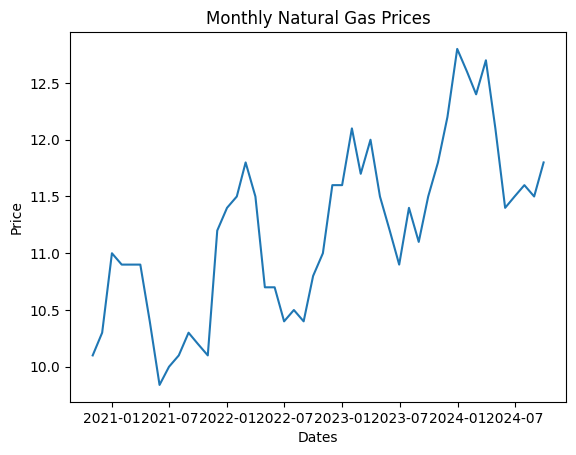

In [22]:
# Visualize data
plt.plot(data.index, data['Prices'])
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('Monthly Natural Gas Prices')
plt.show()


In [36]:
first_diff = data.diff()[1:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


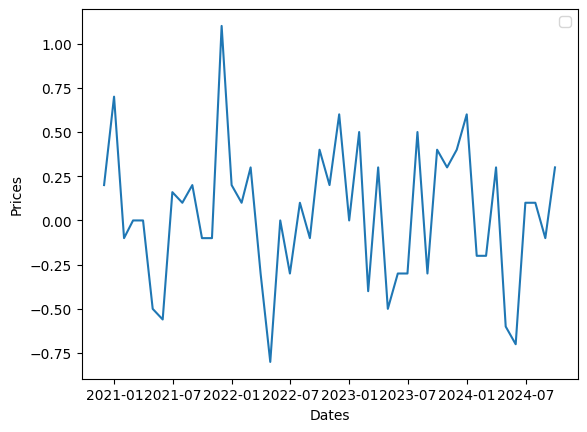

In [39]:
plt.plot(first_diff)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

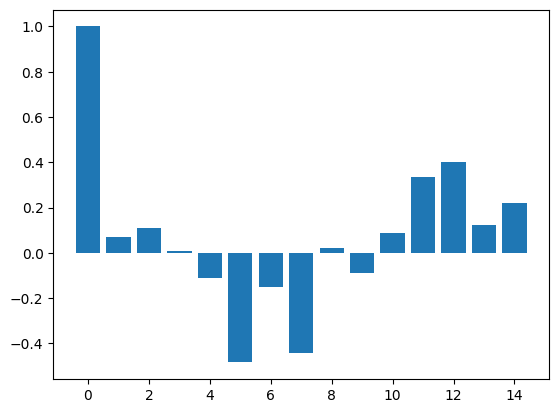

In [51]:
acf_vals =acf(first_diff)
num_lags = 15
plt.bar(range(num_lags),acf_vals[:num_lags])

<BarContainer object of 17 artists>

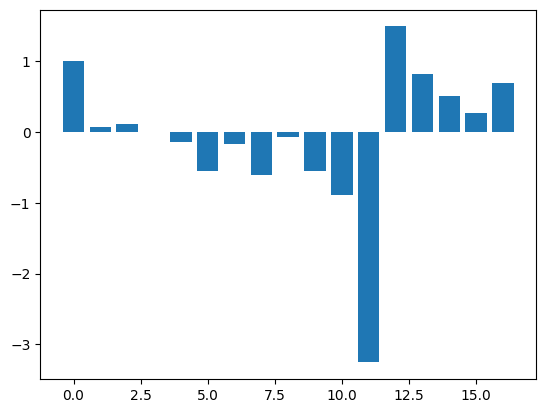

In [57]:
pacf_vals= pacf(first_diff)
num_lags = 17
plt.bar(range(num_lags),pacf_vals[:num_lags])

In [23]:
# Train/test split
train = data[:int(len(data) * 0.8)].copy()
train = train.astype(float)

test = data[int(len(data) * 0.8):].copy()

In [91]:
# Fit SARIMA model
model = SARIMAX(train['Prices'], order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))
start_time = time()
model_fit = model.fit()
end_time = time()
print('The time required for fitting is:',end_time - start_time)

The time required for fitting is: 0.06066751480102539


c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [92]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               Prices   No. Observations:                   38
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -13.746
Date:                              Sat, 29 Jul 2023   AIC                             33.492
Time:                                      21:57:09   BIC                             38.325
Sample:                                  10-31-2020   HQIC                            35.196
                                       - 11-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5574      0.855      0.652      0.515      -1.119       2.234
ma.S.L12      -0.10

In [93]:
# Getting predictions and residuals
predictions = model_fit.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test['Prices'] - predictions


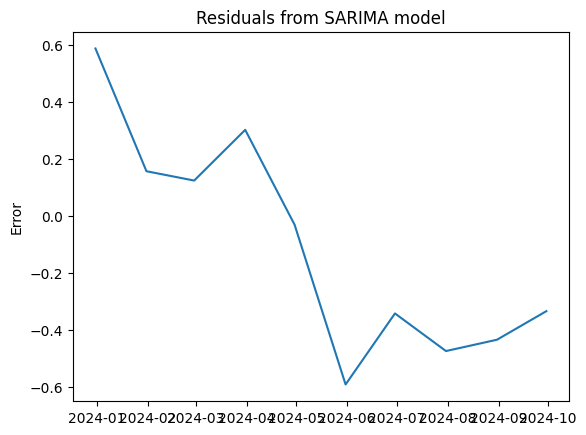

In [94]:
plt.plot(residuals)
plt.title('Residuals from SARIMA model')
plt.ylabel('Error')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


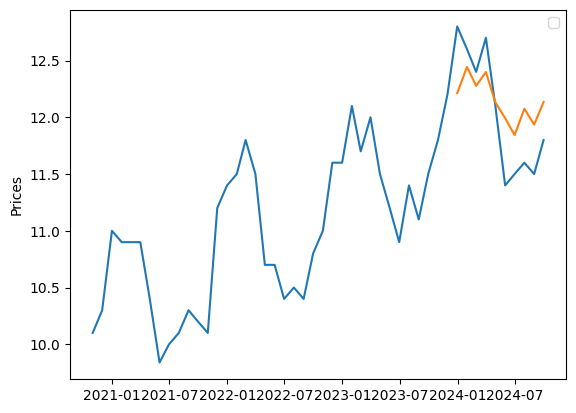

In [95]:
plt.plot(data['Prices'])
plt.plot(predictions)
plt.ylabel('Prices')
plt.legend()
plt.show()

In [96]:
# Make rolling forecasts on the test set
predictions1 = []

for i in range(len(test)):
    model = SARIMAX(
        pd.concat([train['Prices'], test.iloc[:i]['Prices']]),
        order=(0, 1, 0),
        seasonal_order=(1, 0, 1, 12),
    )
    model_fit = model.fit()
    next_month = model_fit.forecast(steps=1)
    predictions1.append(next_month[0])

c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\s

In [97]:
rolling_residuals = test['Prices'] - predictions1

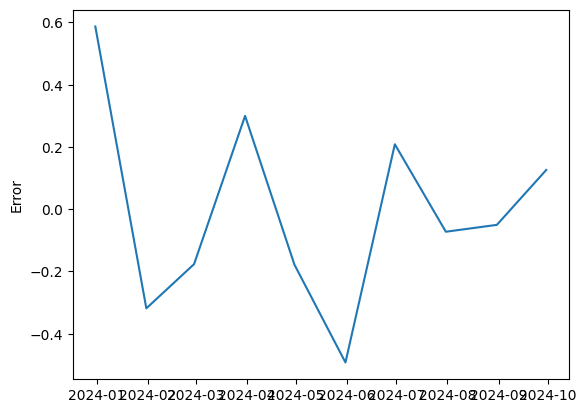

In [98]:
plt.plot(rolling_residuals)
plt.ylabel('Error')

plt.show()

In [99]:
# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(test['Prices'], predictions1))
print('Rolling RMSE: %.2f' % rmse)

Rolling RMSE: 0.30


In [101]:
def forecast_price(date):

  model = SARIMAX(pd.concat([data['Prices'].loc[:datetime.strptime(date, '%Y-%m-%d')]]), order=(0,1,0), seasonal_order=(1,0,1,12))
  
  model_fit = model.fit()  

  steps = (datetime.strptime(date, '%Y-%m-%d').year - data.index[-1].year)*12 + (datetime.strptime(date, '%Y-%m-%d').month - data.index[-1].month)

  forecast = model_fit.forecast(steps=steps)  

  return forecast[steps-1]

In [106]:
# Example usage
price = forecast_price('2025-4-08')
print('2025-3-30 Price Forecast: %.2f' % price)

2025-3-30 Price Forecast: 12.24


c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\91878\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
